In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Uncomment the next two lines if running for the book
# import warnings
# warnings.filterwarnings("ignore")

import jax
from jax import vmap
import jax.random as jrandom
import jax.numpy as jnp
import pandas as pd
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Optional
from jaxtyping import Float, Array

jax.config.update("jax_enable_x64", True)
key = jrandom.PRNGKey(0);

# Example of a Neural Network Surrogate

## Model for subcutaneous autoinjectors

In this notebook, we'll replicate [Sree et. al. (2023)](https://doi.org/10.1016/j.jmbbm.2023.105695) by creating a neural network (NN) surrogate of an expensive biomechanical model.

### Background

Autoinjectors are drug delivery devices that work kind of like an automated syringe. 
Basically, you put the device against the patient's skin, press a button, and a spring within the device pushes the needle and drug is released into the patient.
<!-- Autoinjectors are nice because they simplify the injection process for the user so that patients can self-administer at home.  -->

<img src="https://raw.githubusercontent.com/PredictiveScienceLab/advanced-scientific-machine-learning/refs/heads/main/book/images/autoinjector.png" alt="autoinjector" width="400"/>

*Picture of an autoinjector (taken from [here](https://taltz.lilly.com/taking-taltz)).*

To efficently design an optimal autoinjector, you need a computational model of the injection process.
To this end, [Sree et. al. (2023)](https://doi.org/10.1016/j.jmbbm.2023.105695) present a biomechanical model for injections into subcutaneous tissue (i.e., the tissue right below your skin) via an autoinjector.

<img src="https://raw.githubusercontent.com/PredictiveScienceLab/advanced-scientific-machine-learning/refs/heads/main/book/images/coupled-injection-model.png" alt="coupled-injection-model" height="300"/> 
<img src="https://raw.githubusercontent.com/PredictiveScienceLab/advanced-scientific-machine-learning/refs/heads/main/book/images/injection-simulation.png" alt="injection-simulation" height="300"/> 

**Left:** *Schematic of the autoinjector model.* **Right:** *Finite element simulation of tissue stress during injection.* *From Sree et. al. (2023).* 

The model, however, is expensive to evaluate&mdash;one evaluation takes multiple hours on several parallel processors.
This is too slow for things like design optimization or uncertainty quantification.
So we will speed it up by training a surrogate.
Let's get started.

### Dataset

To train the surrogate, we'll use a dataset with thousands of evaluations of the expensive model (data was provided by the authors [Sree et. al.](https://doi.org/10.1016/j.jmbbm.2023.105695)).
Let's import the data:

In [2]:
# Define new names for each input/output variable
old_input_names = ['mu', 'fill_volume', 'hGap0', 'lNeedle', 'dNeedle', 'FSpring0', 'kSpring', 'kappa5', 'kappa6', 'kappa7']
INPUT_NAMES = ['viscosity_cP', 'fill_volume_mL', 'air_gap_height_mm', 'needle_length_mm', 'needle_diameter_mm', 'spring_force_N', 'spring_constant_N_per_mm', 'kappa5', 'kappa6', 'kappa7']
old_output_names = ['Needle displacement (m)', 'Injection time (s)', 'max. acceleration (m/s^2)', 'max. deceleration (m/s^2)']
OUTPUT_NAMES = ['needle_displacement_m', 'injection_time_s', 'max_acceleration_m_per_s2', 'max_deceleration_m_per_s2']
column_name_mapper = dict(zip(old_input_names + old_output_names, INPUT_NAMES + OUTPUT_NAMES))

# Load the data
train_data = pd.read_excel("../../data/training_data.xlsx", index_col=0).rename(columns=column_name_mapper).sample(frac=1).reset_index(drop=True)
test_data = pd.read_excel("../../data/test_data.xlsx", index_col=0).rename(columns=column_name_mapper).sample(frac=1).reset_index(drop=True)

# Split data. Pass in column names to ensure correct order.
X_train = pd.DataFrame(train_data[INPUT_NAMES], columns=INPUT_NAMES)  
y_train = pd.DataFrame(train_data[OUTPUT_NAMES], columns=OUTPUT_NAMES)
X_test = pd.DataFrame(test_data[INPUT_NAMES], columns=INPUT_NAMES)
y_test = pd.DataFrame(test_data[OUTPUT_NAMES], columns=OUTPUT_NAMES)

The model has 10 inputs and 4 outputs. The inputs are things like drug viscosity, needle size, tissue biomechanical properties, etc. The outputs are the maximum acceleration/deceleration of fluid in syringe, the total time of injection, and the depth of needle insertion at the onset of drug delivery.

### Preprocessing

Ideally, we want the input and output data to be standarized and more-or-less evenly distributed. This helps avoid any numerical difficulties in training. 

Let's visualize the distribution of each input:

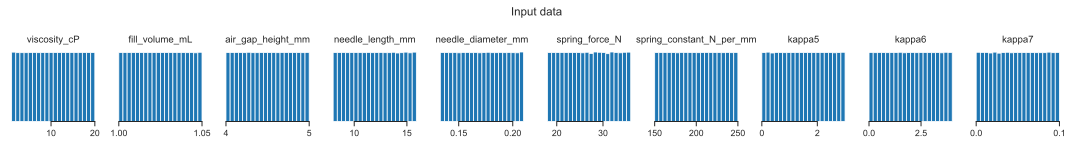

In [3]:
fig, ax = plt.subplots(1, X_train.shape[1], figsize=(15, 2), tight_layout=True, sharey=True)
fig.suptitle("Input data")
for i, col in enumerate(INPUT_NAMES):
    ax[i].hist(X_train[col], bins=20)
    ax[i].set_title(col)
    ax[i].set_yticks([])
    sns.despine(trim=True, ax=ax[i], left=True)

They are evenly distributed, but not standardized (i.e., the means and standard deviations are not 0 and 1, respectively). Let's standardize the input data:

In [4]:
class StandardScaler:
    """A transform that standarizes the data to have mean=0 and stdev=1.
    
    Parameters
    ----------
    data : Float[Array, "N d"]
        The data to be standarized. Shape is (N, d)=(number of samples, dimensionality).
    pretransform_forward : Optional[callable]
        An optional transformation to apply to the data before standarizing.
    pretransform_inverse : Optional[callable]
        The inverse of pretransform_forward.
    """
    def __init__(
        self, 
        data: Float[Array, "N d"], 
        pretransform_forward: Optional[callable] = None, 
        pretransform_inverse: Optional[callable] = None
    ):
        # Set up pre-transform functions
        if (pretransform_forward is None) ^ (pretransform_inverse is None):
            raise ValueError("Both pretransform_forward and pretransform_inverse must be provided.")
        elif pretransform_forward is None:
            pretransform_forward = lambda x: x
            pretransform_inverse = lambda x: x
        self.pre_forward = pretransform_forward
        self.pre_inverse = pretransform_inverse
        
        # Compute parameters for the standardizer
        pretransformed_data = vmap(self.pre_forward)(data)
        self.mean = jnp.mean(pretransformed_data, axis=0)
        self.std = jnp.std(pretransformed_data, axis=0)        
    
    def forward(self, x):
        return (self.pre_forward(x) - self.mean) / self.std
    
    def inverse(self, y):
        return self.pre_inverse(y * self.std + self.mean)

In [5]:
input_transform = StandardScaler(X_train.values)
X_train_scaled = vmap(input_transform.forward)(X_train.values)
X_test_scaled = vmap(input_transform.forward)(X_test.values)

Now let's visualize the distribution of each output:

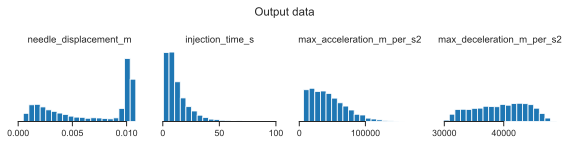

In [6]:
fig, ax = plt.subplots(1, y_train.shape[1], figsize=(8, 2), tight_layout=True, sharey=True)
fig.suptitle("Output data")
for i, col in enumerate(OUTPUT_NAMES):
    ax[i].hist(y_train[col], bins=20)
    ax[i].set_title(col)
    ax[i].set_yticks([])
    sns.despine(trim=True, ax=ax[i], left=True)

Some of the outputs are skewed. Let's apply a log transformation, then standardize the output data:

In [7]:
def partial_log_transform(x):
    return jnp.hstack([x[0], jnp.log(x[1]), jnp.log(x[2]), x[3]])

def partial_exp_transform(y):
    return jnp.array([y[0], jnp.exp(y[1]), jnp.exp(y[2]), y[3]])

output_transform = StandardScaler(y_train.values, pretransform_forward=partial_log_transform, pretransform_inverse=partial_exp_transform)
y_train_scaled = vmap(output_transform.forward)(y_train.values)
y_test_scaled = vmap(output_transform.forward)(y_test.values)

Okay, now let's visualize the transformed inputs and outputs:

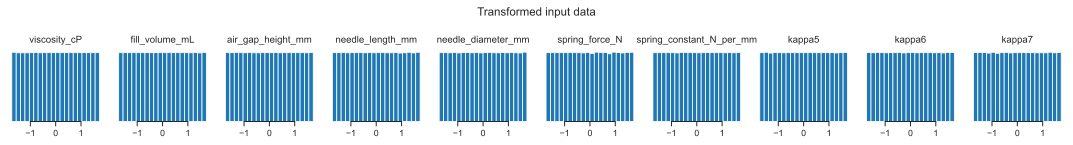

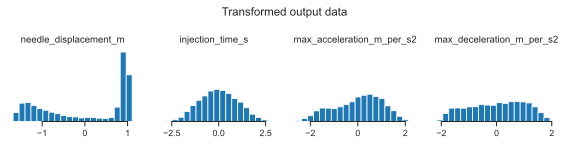

In [8]:
fig, ax = plt.subplots(1, X_train_scaled.shape[1], figsize=(15, 2), tight_layout=True, sharey=True)
fig.suptitle("Transformed input data")
for i, i_name in enumerate(INPUT_NAMES):
    ax[i].hist(X_train_scaled[:, i], bins=20)
    ax[i].set_title(i_name)
    ax[i].set_yticks([])
    sns.despine(trim=True, ax=ax[i], left=True)

fig, ax = plt.subplots(1, y_train_scaled.shape[1], figsize=(8, 2), tight_layout=True, sharey=True)
fig.suptitle("Transformed output data")
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].hist(y_train_scaled[:, i], bins=20)
    ax[i].set_title(o_name)
    ax[i].set_yticks([])
    sns.despine(trim=True, ax=ax[i], left=True)

Nice! The input/output data are all more-or-less evenly distributed and standardized. 
Now on to building the neural network surrogate.

## Creating the NN surrogate

Let's set aside some of the training data for on-the-fly validation during training:

In [10]:
X_train_scaled_subset, X_val_scaled = jnp.split(X_train_scaled, [int(0.9 * X_train_scaled.shape[0])])
y_train_scaled_subset, y_val_scaled = jnp.split(y_train_scaled, [int(0.9 * y_train_scaled.shape[0])])

The best choice of neural network architecture is problem dependent. 
We'll just use a simple MLP with 5 hidden layers and 100 neurons per layer.

Define the training loop:

In [11]:
def dataloader(X, y, batch_size, shuffle=True):
    num_samples = X.shape[0]
    indices = np.arange(num_samples)
    if shuffle:
        np.random.shuffle(indices)
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]

def train(
    batch_size: int,
    max_epochs: int,
    max_iters: int,
    learning_rate: float,
    X_train: Array,
    y_train: Array,
    X_val: Array,
    y_val: Array,
    loss_freq: int = 20,
    save_freq: int = 100,
    print_freq: int = 1000,
    *, 
    key
):
    if max_epochs is None and max_iters is None:
        raise ValueError("Either max_epochs or max_iters must be provided.")
    elif max_epochs is None:
        max_epochs = np.inf
    elif max_iters is None:
        max_iters = np.inf

    model = eqx.nn.MLP(in_size=10, out_size=4, width_size=100, depth=5, key=key)
    optimizer = optax.adam(learning_rate)
    optim_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
    train_losses = []
    val_losses = []

    _epoch_counter, _iter_counter = 0, 0
    _reached_max_iters = False
    _accumulated_train_loss, _accumulated_val_loss, _N_loss = 0.0, 0.0, 0

    @eqx.filter_jit
    def compute_loss(model, X, y):
        y_pred = vmap(model)(X)
        return jnp.mean((y - y_pred)**2)

    @eqx.filter_jit
    def make_step(model, X, y, opt_state, optimizer):
        loss, grads = eqx.filter_value_and_grad(compute_loss)(model, X, y)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss
    
    # Training loop
    while _epoch_counter < max_epochs:
        for xb, yb in dataloader(X_train, y_train, batch_size):

            # Update the model
            model, optim_state, loss = make_step(model, xb, yb, optim_state, optimizer)
            
            # Add to the running loss totals
            if _iter_counter % loss_freq == 0:
                _accumulated_train_loss += loss
                _accumulated_val_loss += compute_loss(model, X_val, y_val)
                _N_loss += 1

            # Save the running average of the loss
            if _iter_counter % save_freq == 0:
                train_losses.append(_accumulated_train_loss/_N_loss)
                val_losses.append(_accumulated_val_loss/_N_loss)
                _accumulated_train_loss, _accumulated_val_loss, _N_loss = 0.0, 0.0, 0

            # Print the loss
            if _iter_counter % print_freq == 0:
                print(f"Epoch {_epoch_counter:<4}, iter {_iter_counter:<5}, train loss {train_losses[-1]:.4f}, val loss: {val_losses[-1]:.4f}")
            
            if _iter_counter >= max_iters:
                _reached_max_iters = True
                break
            _iter_counter += 1
        if _reached_max_iters:
            break
        _epoch_counter += 1

    return model, jnp.array(train_losses), jnp.array(val_losses)

Here is how to train the surrogate model using 500 points from the training set:

In [12]:
LOSS_FREQ, SAVE_FREQ, PRINT_FREQ = 20, 100, 1000
MAX_ITERS = 5000

key, subkey = jrandom.split(key)
trained_mlp, train_losses, val_losses = train(
    batch_size=128,
    max_epochs=None,
    max_iters=MAX_ITERS,
    learning_rate=1e-3,
    X_train=X_train_scaled_subset[:500],
    y_train=y_train_scaled_subset[:500],
    X_val=X_val_scaled,
    y_val=y_val_scaled,
    loss_freq=LOSS_FREQ,
    save_freq=SAVE_FREQ,
    print_freq=PRINT_FREQ,
    key=subkey
)

Epoch 0   , iter 0    , train loss 0.9686, val loss: 1.0007
Epoch 250 , iter 1000 , train loss 0.0012, val loss: 0.0219
Epoch 500 , iter 2000 , train loss 0.0002, val loss: 0.0212
Epoch 750 , iter 3000 , train loss 0.0003, val loss: 0.0205
Epoch 1000, iter 4000 , train loss 0.0001, val loss: 0.0201
Epoch 1250, iter 5000 , train loss 0.0003, val loss: 0.0199


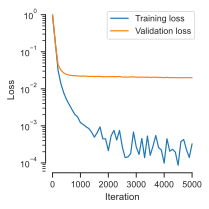

In [13]:
fig, ax = plt.subplots(figsize=(3, 3), tight_layout=True)
iters_plt = np.arange(0, MAX_ITERS + SAVE_FREQ*1e-6, SAVE_FREQ, dtype=int)
ax.plot(iters_plt, train_losses, label="Training loss")
ax.plot(iters_plt, val_losses, label="Validation loss")
ax.set_yscale('log')
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.legend()
sns.despine(trim=True)

We now have a trained surrogate model.

## Diagnostics: How good is the surrogate?

The next question is: **How accurate is our surrogate?** We will use our test dataset to find out.

### Parity plot

Let's plot the predicted output against the true output (for the test dataset), along with the root mean squared error (RMSE):

In [14]:
# Parity plot
y_train_pred = vmap(trained_mlp)(X_train_scaled)
y_test_pred = vmap(trained_mlp)(X_test_scaled)

# Root mean square error
rmse = lambda y, y_hat: jnp.sqrt(jnp.mean((y - y_hat)**2))

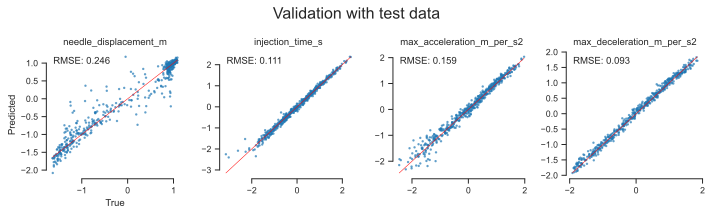

In [15]:
fig, ax = plt.subplots(1, len(OUTPUT_NAMES), figsize=(10, 3), tight_layout=True)
fig.suptitle('Verification with training data', fontsize=16)
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].scatter(y_train_scaled[:, i], y_train_pred[:, i], s=2, alpha=0.3, lw=0.1)
    ax[i].plot(y_train_scaled[:, i], y_train_scaled[:, i], "r-", lw=0.5, zorder=100)
    ax[i].annotate(f"RMSE: {rmse(y_train_scaled[:, i], y_train_pred[:, i]):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
    ax[i].set_title(o_name)
    sns.despine(trim=True, ax=ax[i])
ax[0].set_xlabel('True')
ax[0].set_ylabel('Predicted')

fig, ax = plt.subplots(1, len(OUTPUT_NAMES), figsize=(10, 3), tight_layout=True)
fig.suptitle('Validation with test data', fontsize=16)
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].scatter(y_test_scaled[:, i], y_test_pred[:, i], s=5, alpha=0.7, lw=0.1)
    ax[i].plot(y_test_scaled[:, i], y_test_scaled[:, i], "r-", lw=0.5, zorder=100)
    ax[i].annotate(f"RMSE: {rmse(y_test_scaled[:, i], y_test_pred[:, i]):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
    ax[i].set_title(o_name)
    sns.despine(trim=True, ax=ax[i])
ax[0].set_xlabel('True')
ax[0].set_ylabel('Predicted');

The closer the points are to the red line, the more accurate the surrogate is.
This looks pretty good for only training on 500 points.
Let's try to improve it with more training data.

## Convergence: How much data do we need?

The more data you have available to train the surrogate, the better.
In fact, you should see the prediction error go to zero as you increase the amount of training data (so long as the neural network is *expressive enough* and you *train for long enough*).
<!-- However, it's often difficult to know beforehand exactly how much data you need. -->

Let's observe this convergence behavior by training the same neural network with different dataset sizes:



In [16]:
dataset_sizes = [100, 1000, 2500, 5000, 9000]
trained_mlps_N = {}
train_losses_N = {}
val_losses_N = {}

for N in dataset_sizes:
    print(f"Now training NN with dataset of size {N} ...\n")
    key, subkey = jrandom.split(key)
    trained_mlps_N[N], train_losses_N[N], val_losses_N[N] = train(
        batch_size=128,
        max_epochs=None,
        max_iters=MAX_ITERS,
        learning_rate=1e-3,
        X_train=X_train_scaled_subset[:N],
        y_train=y_train_scaled_subset[:N],
        X_val=X_val_scaled,
        y_val=y_val_scaled,
        loss_freq=LOSS_FREQ,
        save_freq=SAVE_FREQ,
        print_freq=PRINT_FREQ,
        key=subkey
    )
    print("\n...done.\n\n")

Now training NN with dataset of size 100 ...

Epoch 0   , iter 0    , train loss 1.0057, val loss: 1.0043
Epoch 1000, iter 1000 , train loss 0.0002, val loss: 0.0957
Epoch 2000, iter 2000 , train loss 0.0000, val loss: 0.0964
Epoch 3000, iter 3000 , train loss 0.0000, val loss: 0.0984
Epoch 4000, iter 4000 , train loss 0.0000, val loss: 0.0997
Epoch 5000, iter 5000 , train loss 0.0000, val loss: 0.1004

...done.


Now training NN with dataset of size 1000 ...

Epoch 0   , iter 0    , train loss 1.0383, val loss: 1.0080
Epoch 125 , iter 1000 , train loss 0.0029, val loss: 0.0142
Epoch 250 , iter 2000 , train loss 0.0010, val loss: 0.0119
Epoch 375 , iter 3000 , train loss 0.0008, val loss: 0.0118
Epoch 500 , iter 4000 , train loss 0.0006, val loss: 0.0116
Epoch 625 , iter 5000 , train loss 0.0004, val loss: 0.0115

...done.


Now training NN with dataset of size 2500 ...

Epoch 0   , iter 0    , train loss 1.0007, val loss: 1.0041
Epoch 50  , iter 1000 , train loss 0.0047, val loss: 0.0

Let's repeat the parity plots for different amounts of training data:

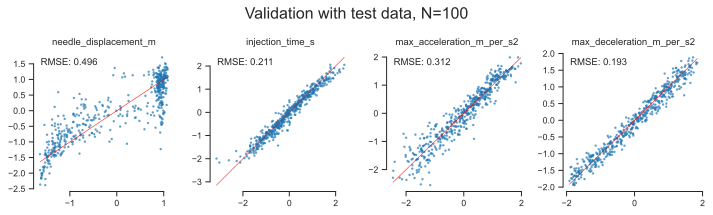

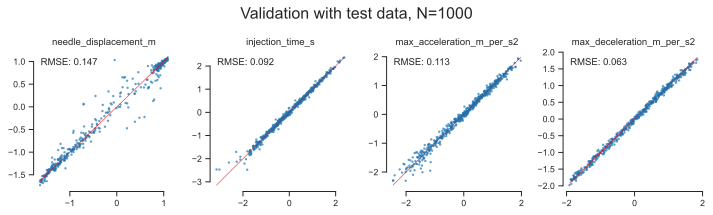

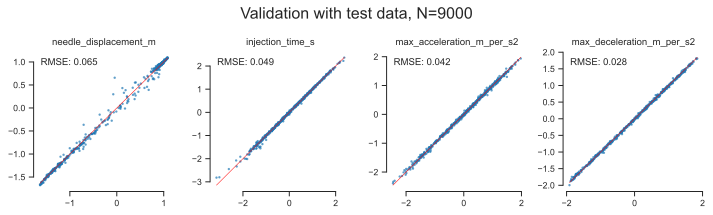

In [17]:
for N in [dataset_sizes[0], dataset_sizes[1], dataset_sizes[-1]]:
    y_test_pred = vmap(trained_mlps_N[N])(X_test_scaled)
    fig, ax = plt.subplots(1, len(OUTPUT_NAMES), figsize=(10, 3), tight_layout=True)
    fig.suptitle(f'Validation with test data, N={N}', fontsize=16)
    for i, o_name in enumerate(OUTPUT_NAMES):
        ax[i].scatter(y_test_scaled[:, i], y_test_pred[:, i], s=5, alpha=0.7, lw=0.1)
        ax[i].plot(y_test_scaled[:, i], y_test_scaled[:, i], "r-", lw=0.5, zorder=100)
        ax[i].annotate(f"RMSE: {rmse(y_test_scaled[:, i], y_test_pred[:, i]):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
        ax[i].set_title(o_name)
        sns.despine(trim=True, ax=ax[i])

Again, the more data, the better. The fit for $N=9,000$ is quite good.

Let's plot the RMSE against the dataset size:

In [18]:
rmse_i = []
for N in dataset_sizes:
    y_test_pred = vmap(trained_mlps_N[N])(X_test_scaled)
    rmse_i.append(vmap(rmse, 1)(y_test_scaled, y_test_pred))
rmse_i = jnp.array(rmse_i)

In [19]:
fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
for i, o_name in enumerate(OUTPUT_NAMES):
    ax.plot(dataset_sizes, rmse_i[:, i], marker='o', label=o_name)
ax.set_title('Surrogate convergence with increasing dataset size', fontsize=12)
ax.set_xlabel("Dataset size")
ax.set_ylabel("RMSE")
ax.legend()
sns.despine(trim=True)

For this problem, the surrogate is pretty good when trained on 2,000 (or more) points.
We could probably further improve accuracy by training for longer or using a different NN architecture.

## Sensitivity analysis with surrogate

Now that we have a trained and tested surrogate, there are many useful things we can do with it. As an example, we'll demonstrate using the surrogate to do Sobol sensitivity analysis.

First, let's create a helper function for evaluating the *unscaled* surrogate model.

In [21]:
def _surrogate(x, nn_model):
    x_scaled = input_transform.forward(x)
    y_scaled = nn_model(x_scaled)
    y = output_transform.inverse(y_scaled)
    return y

# This is the unscaled surrogate.
surrogate = partial(_surrogate, nn_model=trained_mlps_N[9000])

Now, let's create bounds for the inputs (based on physical intuition and/or literature values):

In [22]:
import SALib.sample.sobol as sobol
import SALib.analyze.sobol as analyze_sobol

input_bounds_dict = {
    'viscosity_cP': [1.0, 20.0],
    'fill_volume_mL': [1.0, 1.05],
    'air_gap_height_mm': [4.0, 5.0],
    'needle_length_mm': [8.0, 15.9],
    'needle_diameter_mm': [0.133, 0.21],
    'spring_force_N': [18.0, 36.0],
    'spring_constant_N_per_mm': [150.0, 250.0],
    'kappa5': [0.0, 3.0],
    'kappa6': [0.0, 4.0],
    'kappa7': [0.0, 0.1]
}
input_bounds = np.array([[input_bounds_dict[i][0], input_bounds_dict[i][1]] for i in INPUT_NAMES])
print('The input bounds are:\n', input_bounds)

The input bounds are:
 [[1.00e+00 2.00e+01]
 [1.00e+00 1.05e+00]
 [4.00e+00 5.00e+00]
 [8.00e+00 1.59e+01]
 [1.33e-01 2.10e-01]
 [1.80e+01 3.60e+01]
 [1.50e+02 2.50e+02]
 [0.00e+00 3.00e+00]
 [0.00e+00 4.00e+00]
 [0.00e+00 1.00e-01]]


Next, we create Sobol samples of the inputs and pass them through the surrogate:

In [23]:
problem = {
    'num_vars': len(INPUT_NAMES),
    'names': INPUT_NAMES,
    'bounds': input_bounds
}

# The number of samples to generate (should be a power of 2).
N = 512

# Generate the samples.
sobol_samples = sobol.sample(problem, N, calc_second_order=False)

# Evaluate the surrogate model at the Sobol samples.
sobol_outputs = vmap(surrogate)(sobol_samples)

Finally, we calculate and plot the Sobol indices:

In [24]:
sobol_indices = {}
for i, o_name in enumerate(OUTPUT_NAMES):
    sobol_indices[o_name] = analyze_sobol.analyze(problem, sobol_outputs[:, i], calc_second_order=False, print_to_console=False)

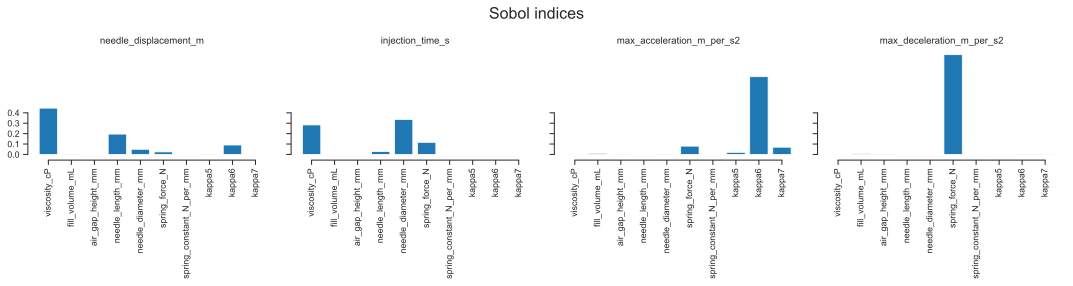

In [25]:
# Plot sobol indices
fig, ax = plt.subplots(1, len(OUTPUT_NAMES), figsize=(15, 4), tight_layout=True, sharey=True)
fig.suptitle('Sobol indices', fontsize=16)
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].bar(problem['names'], sobol_indices[o_name]['S1'])
    ax[i].set_title(o_name)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)
    sns.despine(trim=True, ax=ax[i])

Excellent! We now know to which inputs the outputs are most sensitive. For example, we can see that the injection time is *very* sensitive to the drug viscosity and needle diameter, *somewhat* sensitive to needle length and injector spring force, and *not* sensitive to any other inputs. This information can be used, for example, to further study and understand the physics behind the model, or to investigate how identifiable each parameter is given an experimental dataset.

Remember that **sensitivity analysis would *not* have been feasible without a surrogate model**&mdash;the true physical model was just too expensive. With a surrogate however, we can do sensitivity analysis, design optimization, uncertainty quantification, etc. all at a reasonable computational cost.